## COVID19 in DK

A simple SIR model fitted to COVID19 cases in Denmark. This is written mostly for my own curiosity.

In [1]:
library(deSolve)
library(ggplot2)
library(rstan)
options(mc.cores = parallel::detectCores())
rstan_options(auto_write= TRUE)

Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



Initial conditions.

In [2]:
Ninit = 5.8e6          # Total population
Iinit = 500            # initial fraction infected
Sinit = Ninit - Iinit  # initial fraction susceptible
Rinit = 0              # no one recovered 

Initial guess for the parameters. It is assumed that $1/\gamma$ corresponds to the average number of days to recover from COVID19. $\beta$ is the rate of infection transmission. 

In [3]:
beta = 1.0/7.0
gamma = 0.06
print(beta)
print(gamma)

[1] 0.1428571
[1] 0.06


$R_0$ is the reproduction number. 

In [4]:
R0factor= beta/gamma
print(R0factor)

[1] 2.380952


Data structures.

Time intervals defined in days. Integration is done over one year. 

In [5]:
theta <- list(beta = beta,
              gamma = gamma)
inits <- c(Sinit, Iinit, Rinit)

In [6]:
t_min = 0
t_max = 365
times = t_min:t_max

The SIR model (Suceptible, Infected and Recovered) is given as
\begin{eqnarray}
    &\frac {dS} {dt} = - \beta \cdot S\cdot \frac {I} {N}\\
    &\frac {dI} {dt} =  \beta \cdot S\cdot \frac {I} {N} - \gamma \cdot I\\
    &\frac {dR} {dt} = \gamma \cdot I
\end{eqnarray}
where $N= S+I+R$

Plot of the solution.

In [7]:
SIR <- function(t, y, theta) {
    with(as.list(c(theta, y)), {
        S = y[1]
        I = y[2]
        R = y[3]
        N = S+I+R
    
        dS = - beta * S/N * I
        dI = beta * S/N * I - gamma * I
        dR = gamma * I
    
        res <- c(dS,dI,dR)
        list(res)
    })
}
out <- ode(inits, times, SIR, theta, method="ode45")
out <- data.frame(out)
colnames(out) <- c("time", "S", "I", "R")

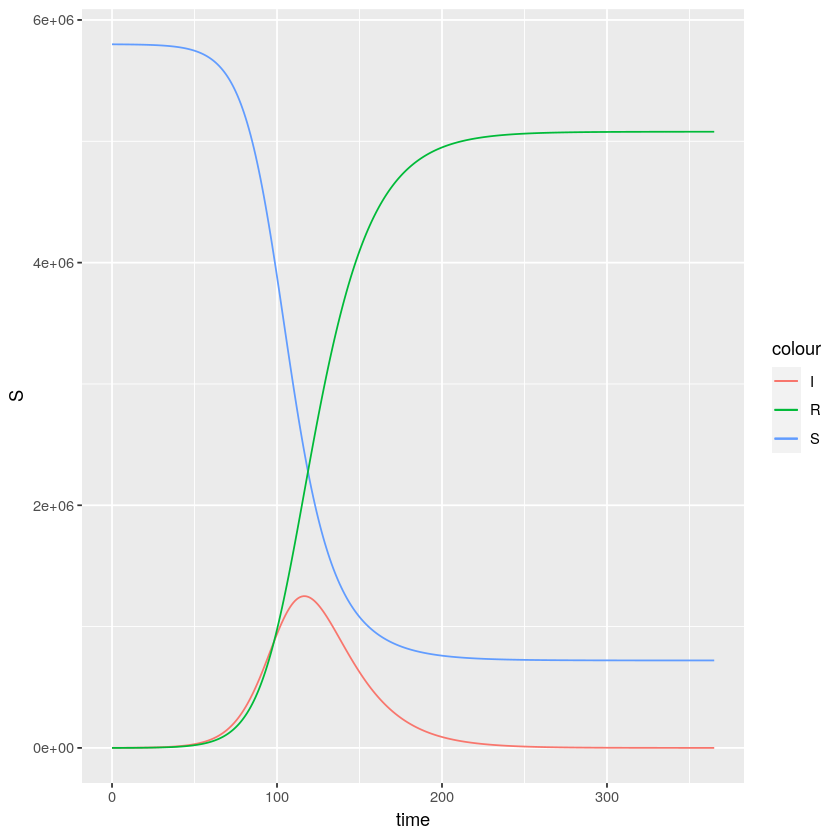

In [8]:
# quick plot of the epidemic
ggplot(out, aes(time)) +
    geom_line(aes(y = S, colour = "S"))+
    geom_line(aes(y = I, colour = "I"))+
    geom_line(aes(y = R, colour = "R"))

Here herd imunity is reached after approximately 200 days.

## Estimating infection transmission
The $\beta$ parameter controlling the spread of infection can be estimated by assuming a number of contacts and a transmission probability. 
Assume that every person meets 30 people pr day, and the probability of transmitting infection is 

In [9]:
print(beta/30,1)

[1] 0.005


This corresponds to the $R_0=2.44$, which was reported as the reproduction number in the initial phase of the COVID19 epidemic. 

Lets assume that weak measures are imposed and the transmission probability is reduced to $1/300$. This could be due to social distancing and due to improved cleaning and hygine. Still, the number of people incounters are kept equal. This gives a new transmission coefficient $\beta_2$

In [10]:
beta2 = 30/300
R_0 = beta2/gamma
print(beta2)
print(gamma)
print(R_0)

[1] 0.1
[1] 0.06
[1] 1.666667


The new parameters are introduced into the model. 

In [11]:
theta <- list(beta = beta2,
              gamma = gamma)
inits <- c(Sinit, Iinit, Rinit)
t_min = 0
t_max = 360
times = t_min:t_max
SIR <- function(t, y, theta) {
    with(as.list(c(theta, y)), {
        S = y[1]
        I = y[2]
        R = y[3]
        N = S+I+R
    
        dS = - beta * S/N * I
        dI = beta * S/N * I - gamma * I
        dR = gamma * I
    
        res <- c(dS,dI,dR)
        list(res)
    })
}
out2 <- ode(inits, times, SIR, theta, method="ode45")
out2 <- data.frame(out2)
colnames(out2) <- c("time", "S", "I", "R")

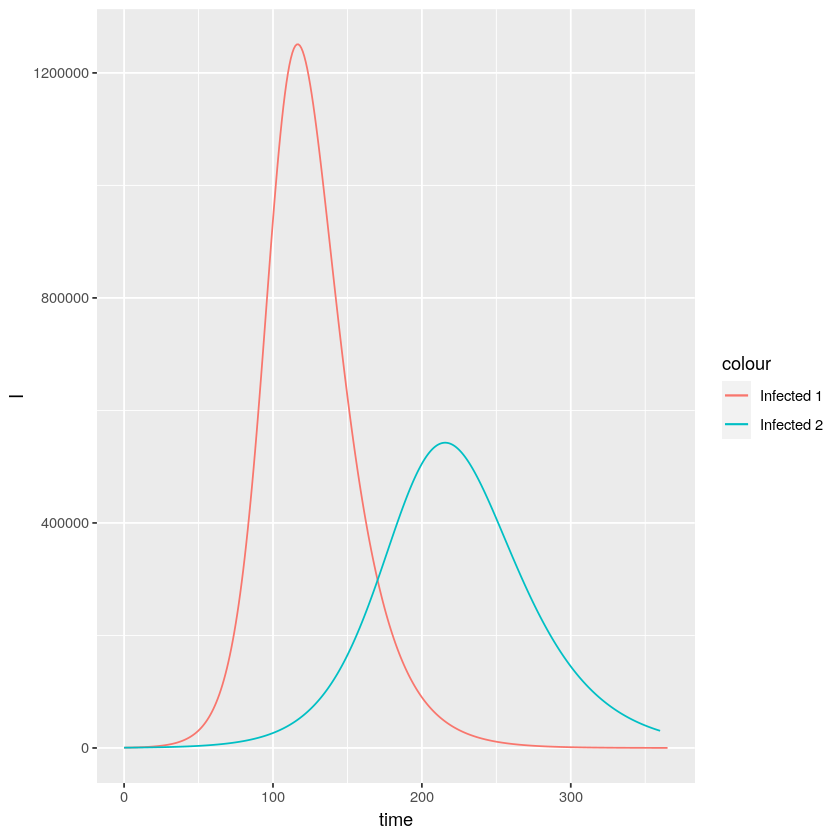

In [12]:
## Still learning to ggplot.
ggplot(NULL, aes(time, I)) + 
    geom_line(data = out, aes(colour="Infected 1")) +
    geom_line(data = out2, aes(colour="Infected 2"))

The lockdown in Denmark has reduced the number of encounters between people; lets assumed 8 people per day. Furthermore, the requirement for 2m distancing and increased hygine has reduced the transmission probability; lets assume $1/200$. Then, the parameters of the model are given as: 

In [13]:
beta3 = 8/200
R_0 = beta3/gamma
print(R_0)

[1] 0.6666667


It is seen that the estimate for $R_0$ is close to the current estimate of 0.7. The evolution of infections is illustrated below. The initial conditions are changed to show the effect of lockdown after a number of persons have been infected.

In [14]:
starttime3 = 70
Ninit = 5.8e6          # Total population
Iinit = out$I[starttime3]      # initial fraction infected
Sinit = Ninit - Iinit  # initial fraction susceptible
Rinit = out$R[starttime3]      # no one recovered
theta <- list(beta = beta3,
              gamma = gamma)
inits <- c(Sinit, Iinit, Rinit)
t_min = starttime3
t_max = 360
times = t_min:t_max
SIR <- function(t, y, theta) {
    with(as.list(c(theta, y)), {
        S = y[1]
        I = y[2]
        R = y[3]
        N = S+I+R
    
        dS = - beta * S/N * I
        dI = beta * S/N * I - gamma * I
        dR = gamma * I
    
        res <- c(dS,dI,dR)
        list(res)
    })
}
out3 <- ode(inits, times, SIR, theta, method="ode45")
out3 <- data.frame(out3)
colnames(out3) <- c("time", "S", "I", "R")

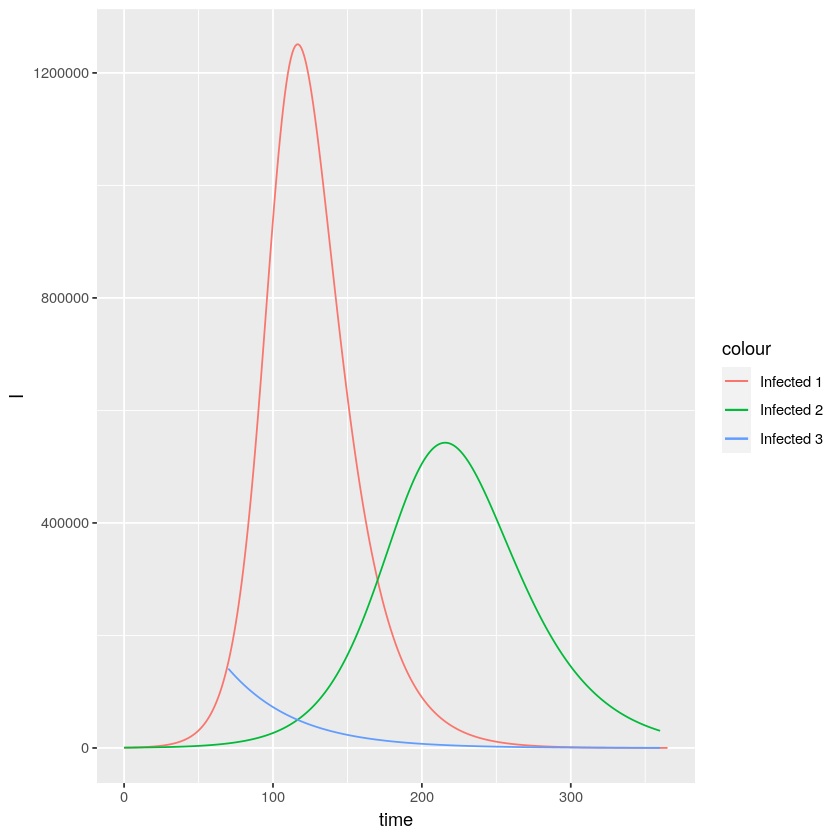

In [15]:
ggplot(NULL, aes(time, I)) + 
    geom_line(data = out, aes(colour="Infected 1")) +
    geom_line(data = out2, aes(colour="Infected 2"))+
    geom_line(data = out3, aes(colour="Infected 3"))

## DOTS
These estimtes follow the DOTS principle. 

- R0 can be quantitatively described as a product of D x O x T x S
- D = duration (number of days someone is infectious)
- O = opportunities for transmission (number of person-person greetings / day)
- T = probability of transmission
- S = susceptibility (proportion of population susceptible)

This has been elaborated (here)[https://www.tibco.com/blog/2020/03/18/covid-19-a-visual-data-science-analysis-and-review/]

# Data fit
Fit data from SSI using STAN

First import data, and secondly select data that will be used for fitting.

In [16]:
dataDK <- read.csv2(file = 'data-2020-05-06/Test_pos_over_time.csv')
dataDK$Dato <- as.Date(dataDK$Dato,"%d. %B")
dataDK$Dag <- as.numeric(row.names(dataDK))
dataDK$Accumuleret_COVID<- cumsum(dataDK$Antal_COVID)

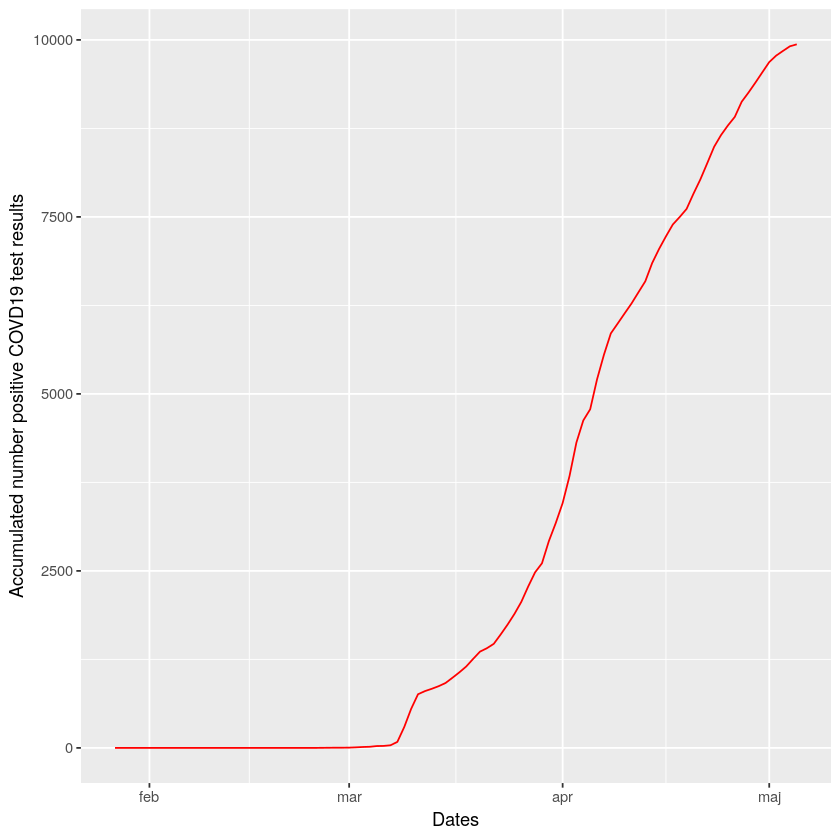

In [17]:
ggplot(dataDK, aes(Dato,Accumuleret_COVID)) +
    geom_line(colour="red") +
    labs(x="Dates", y="Accumulated number positive COVD19 test results")

In [18]:
modelSIR <- stan_model("model_sir2.stan")

The source code for the  [MC-STAN model](mc-stan.org) is shown below. 

Notice the parameters $\beta$ and $\gamma$ will be fitted. However, the data does not contain information regarding the number of people who get well. Thus there is essentially not information for fitting $\gamma$. The parameter $\sigma$, which define the scatter is also fitted. 

In [22]:
file.show("model_sir2.stan")

In [23]:
dataSIR <- list(N = length(dataDK$Dag[50:65]), ts  = dataDK$Dag[50:65]-49,
                N_predict=365, ts_predict = c(1:365),
                y_init = c(5.8e6,dataDK$Accumuleret_COVID[50],0), y = dataDK$Accumuleret_COVID[50:65])

Fit the SIR model to the data obtained around the date 30. March. At this time there have been some discussion in danish media regarding the correct $R_0$ estimate. Here there is still no data for the number of people who leave the infected category. 
Furthermore, the number of tests has increased during the period, so the increase of positive tests may overestimate the infection rate. 

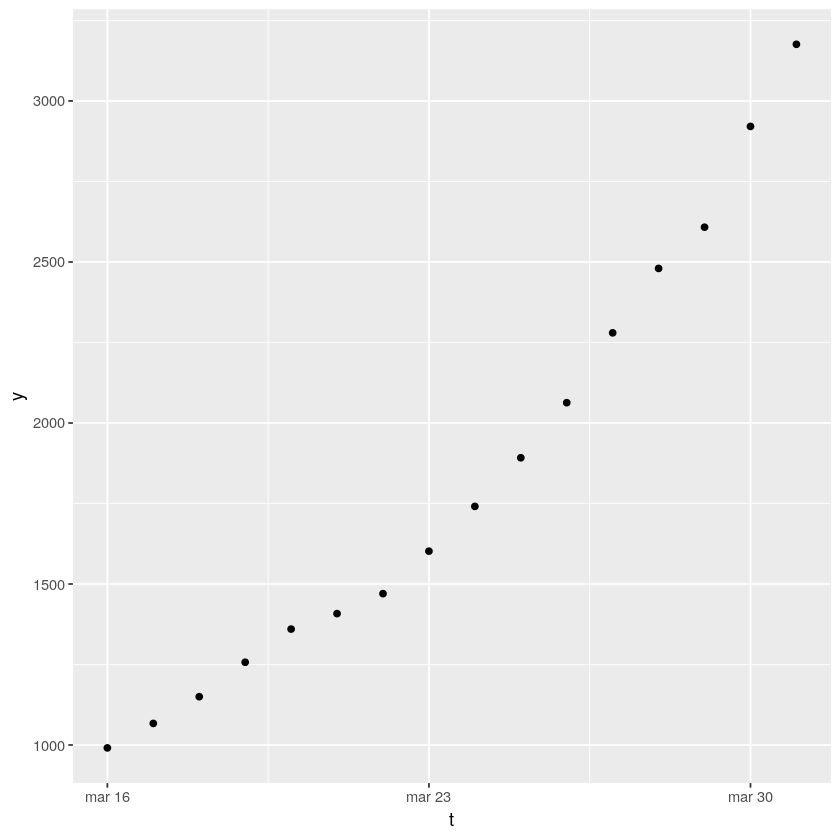

In [24]:
ggplot(data.frame(t=dataDK$Dato[50:65], y=dataSIR$y), aes(t,y)) +
    geom_point()

In [25]:
fitSIR <- sampling(modelSIR, dataSIR, iter=1000, chains=4,
                   control=list(adapt_delta = 0.9, max_treedepth=15))

In [26]:
posts <- extract(fitSIR)

In [27]:
print(fitSIR, pars=c("theta", "sigma", "R0"),
      probs=c(0.1, 0.5, 0.9), digits = 3)

Inference for Stan model: model_sir2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean    sd   10%   50%   90% n_eff  Rhat
theta[1] 0.128   0.000 0.006 0.120 0.128 0.136   753 1.006
theta[2] 0.060   0.000 0.006 0.052 0.060 0.068   785 1.007
sigma    0.060   0.000 0.013 0.046 0.059 0.076   660 1.003
R0       2.144   0.004 0.124 1.999 2.129 2.304   813 1.006

Samples were drawn using NUTS(diag_e) at Thu May 28 21:52:25 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Plot a sampled data of $R_0$ and fit to the normal distribution. 

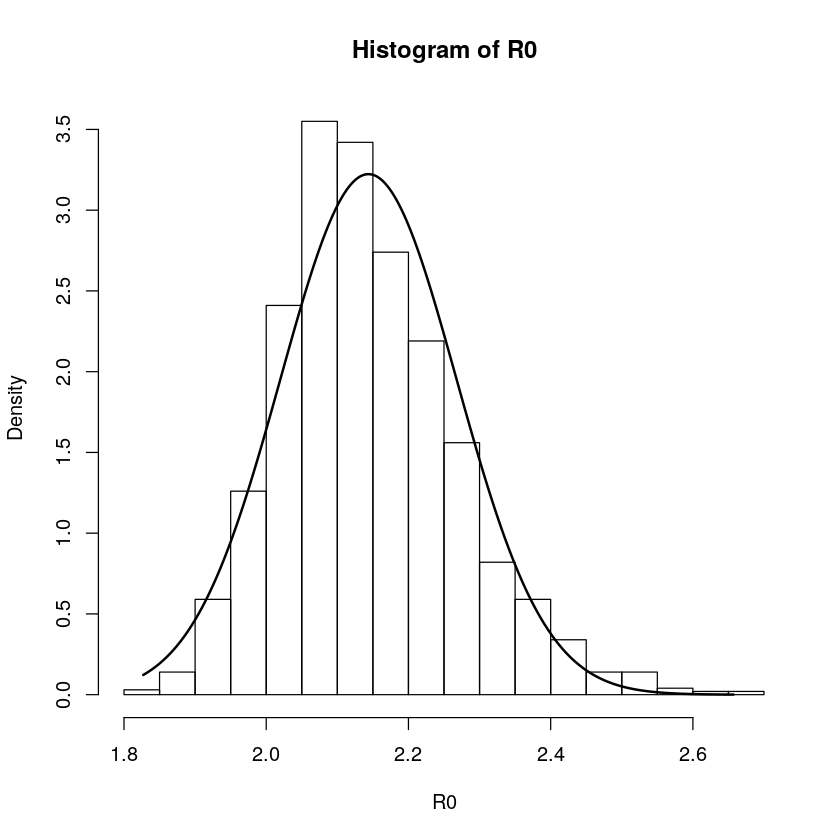

In [28]:
## Plot a histogram of the data.
h <- hist(posts$R0,breaks="Scott", freq=FALSE, xlab = "R0",main="Histogram of R0")
xfit <- seq(min(posts$R0),max(posts$R0),length=400)
yfit <- dnorm(xfit,mean=mean(posts$R0), sd=sd(posts$R0))
lines(xfit,yfit,col="black",lw=2)

Also, the sampling of $\beta$ and $\gamma$ is shown here. 

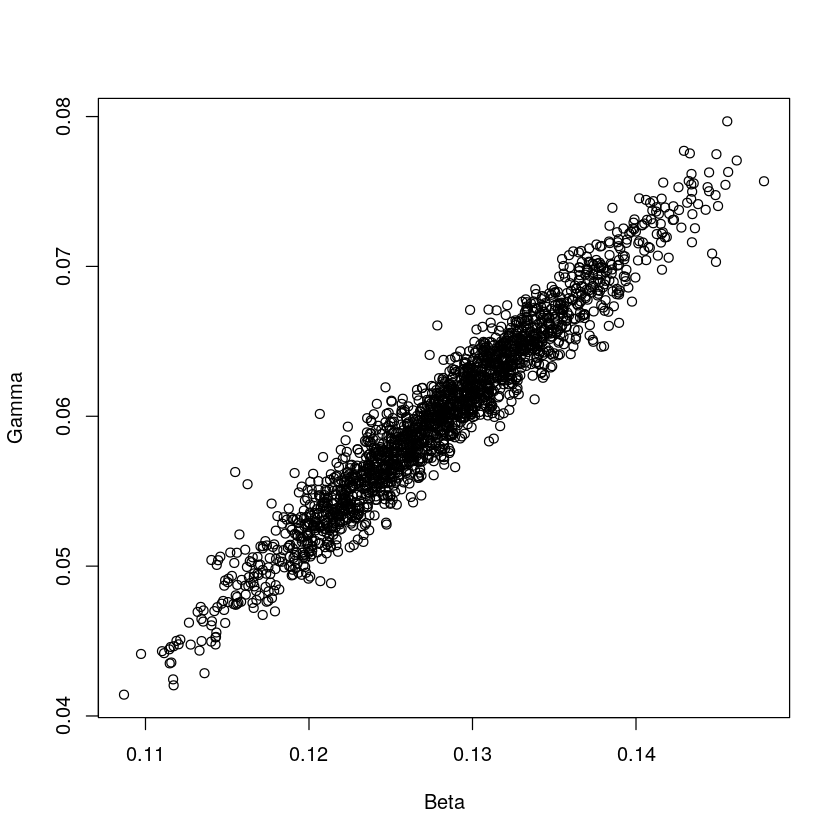

In [29]:
plot(posts$theta[,1],posts$theta[,2],xlab="Beta", ylab="Gamma")

The $R_0$ is found to be about 2.1 from the data fit. This is a very high value, and it mostly shows that the initial data did not provide enough data to give a resonable prediction of the epidemic.

In [30]:
infected_summary <- apply(posts$z_predict[,,2], 2,quantile,probs=c(0.05,0.5,0.95))

In [31]:
infected_s <- data.frame(Dag=dataSIR$ts_predict,Q5=infected_summary[1,],Q50=infected_summary[2,],Q95=infected_summary[3,])

In [32]:
dSIR <- data.frame(Day=dataSIR$ts,Infected=dataSIR$y)

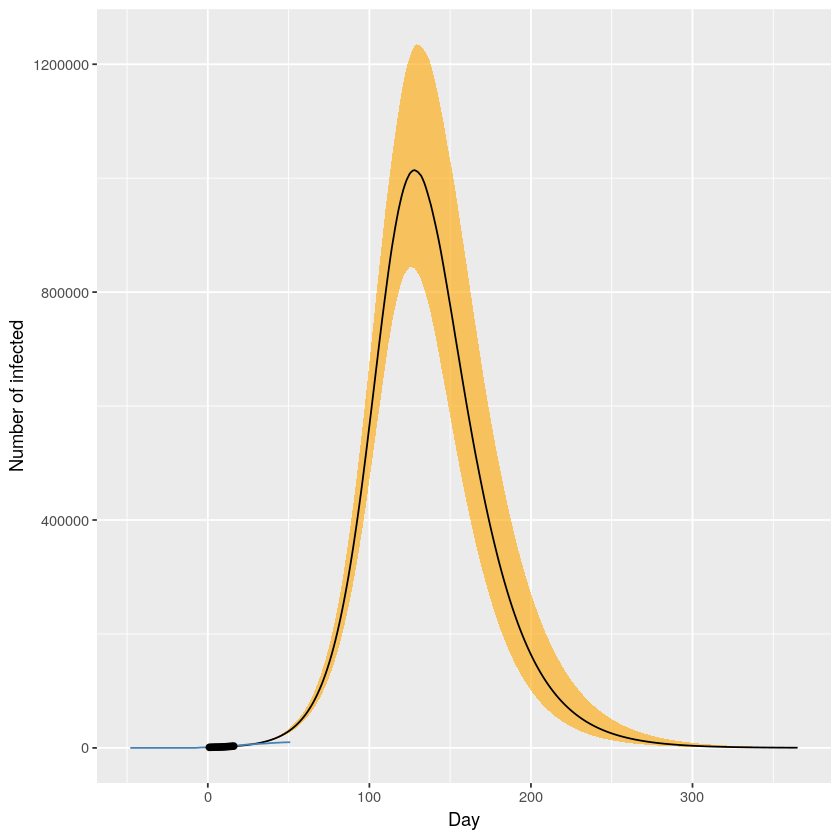

In [33]:
dataDKshift = dataDK
dataDKshift$Dag = dataDK$Dag-49
ex <- ggplot(infected_s, mapping = aes(x = Dag)) +
    geom_ribbon(aes(ymin = Q5, ymax = Q95), fill = "orange", alpha = 0.6) +
    geom_line(mapping = aes(x = Dag, y = Q50)) +
    geom_line(data=dataDKshift,color='steelblue', aes(Dag,Accumuleret_COVID, colour="Actual obs")) +
    geom_point(data=dSIR,aes(Day,Infected))+
    labs(x = "Day", y = "Number of infected")
ex

Below is a close-up of the section where the fitted data is visible. The ribbon shows the confidence intervals, but it does not seem to include the data, and so the uncertainty should have been larger. It seams something was wrong with the fit, or the posterior fit of the data.

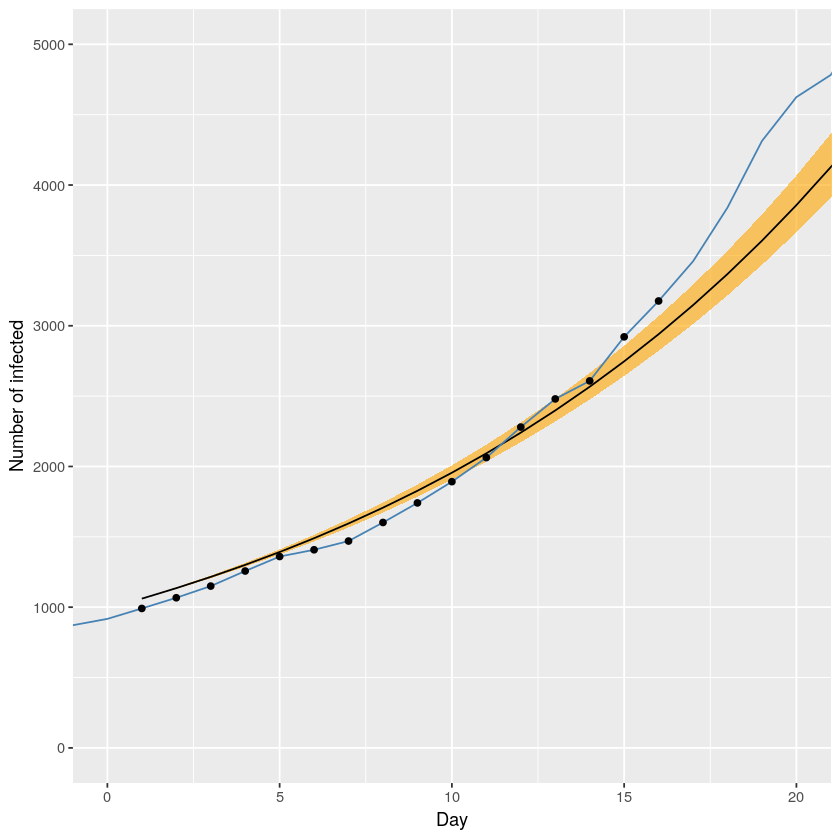

In [34]:
ex + coord_cartesian(xlim = c(0,20),ylim= c(0,5e3))

However, the data shows the period during lock down, so the infection rate should be have been lower than 1. The increase of the infections was most likely due to increase in the number of tests. Furthermore, the total number of infected persons is underestimated due to the undiscovered cases, i.e. the dark numbers.

All, it seems that data fitting is useless based on the available data.

# Background
The SIR model is a model of infectious diseases. It divides the population into compartments of Suceptible, Infected and Recovered people. The model assumed a well mixed population, i.e. it is assumed that every person will meet every other person in the population. The latter is the first limitation of this model. 
A STAN demonstration is given [here](https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html)

# Refined estimate of the infection rates
Instead of data fitting a more phenomelogical model is investigated. 

A prediction of the infection rate is detailed further here. This is done to enable a more detailed estimate of the effects of lock-down measures, and reopening.

Splitting $\beta$ in three $\beta = \beta_{family} + \beta_{close} + \beta_{distant}$ would allow a more detailed estimate of the infection rate. 

Assumming that you have a high probability of infecting your familiy, but a small family would give. 
\begin{equation}
\beta_{family} = O_{family} \cdot T_{family}
\end{equation}

etc.

In [35]:
beta_family <- 5 * 0.01
beta_family

[1] 0.05

Close contacts are contacts whom you know, your friends, your colleagues or similar. A higher number of contacts but a lower probability of transmission is expressed as:

In [36]:
beta_close <- 15 * 0.001
beta_close

[1] 0.015

Distant contacts are people who you may be infected without close contact. People from the supermarket, or other distant contacts. There is very little risk of transmission, but there are many possible contacts. 

At a large public event, e.g. a football match, there could be many contact, but a high probability of transmission. This could be modelled with a high probability here. 

In [37]:
beta_distant <- 100 * 1e-4
beta_distant

[1] 0.01

This gives the following estimate for the total $beta$

In [38]:
beta4 <- beta_family + beta_close + beta_distant
beta4
print("R0 estimate:")
beta4/gamma

[1] 0.075

[1] "R0 estimate:"


[1] 1.25

## Containment measures
There are several ways to reduce the spreading.

Reduction of the number of contacts is very effective. However, this would imply keeping the lockdown in effect for a long time. Seconly, reducing the probability of transferring infections by improved hygeine and isolation of infected persons is effective. 

## Stages of disease 
Another issue is the stages of the disease. 

A common extension of the SIR model is the SEIR model. This model has the compartments suceptible, exposed, infected and recovered. In the exposed phase persons have been exposed to the virus, but do not infect other and show no symptoms. 

The infected case is split into the the infected asymptomatic case, infected symptomatic case, and the infected hospitalized. 

- Asymptomatic cases have virus, and spread by aerosols. Asymptotic persons either recover directly or transfer to the symptomatic case. 

- Symptomatic cases have symptoms and spread by cough and sneezing. These persons either recover directly or transfer to hospital case. 

- Hospitalized cases recover. 

This it can be denoted as a SEIIIR model or SE3IR model.

## Intimacy and stages
Considering both intimacy and stages give a more refined estimate of the transmission rates. Here it gives 3x3 probabilities of transmission and 3x3 number of people a day.
\begin{equation}
\begin{bmatrix}
\beta_{asymp} \\
\beta_{symp} \\
\beta_{hospital}
\end{bmatrix}
= 
\begin{bmatrix}
&0.01 & 10^{-4} & 10^{-6}\\
&0.02 & 0.005 & 0.001\\
&0.02 & 0.005 & 0.001
\end{bmatrix}
\odot
\begin{bmatrix}
&3 & 50 & 1000\\
&3 & 5 & 0\\
&3 & 0 & 0
\end{bmatrix}
\end{equation}
here $\odot$ denotes the Hadamard matrix product.

Notes. 
- The asymptomatic cases have been estimated to be about half of all cases. This it is a relatively important group.
- The transmission probability within family contacts is relatively low. This is most likely a model artefact, since families are not well mixed population. 
- The transmission probability from asymptomatic cases is low, but it is expected that there are many contacts.
- Symptomatic cases are expected to self-isolate for most part, but transmission probability is higher. 
- Hospitalized cases are also isolated from all but intimate contacts. Here there'll be a risk of transmission to healthcare workers. The use and effectiveness of protective equipment will affect the probability of infection.

In [68]:
beta_a = 0.01*3 + 1e-5 * 50 + 1e-6*500
beta_s = 0.02*3 + 0.001 * 5
beta_h = 0.02*3
beta4 <- beta_a + beta_s + beta_h
beta_asymp
beta_symp
beta_hospital
beta4

[1] 0.031

[1] 0.065

[1] 0.04

[1] 0.156

Then additional estimates for parameters

In [115]:
## Rask rate; 1/gamma er den gennemsnitlige varighed af infektionen [1]
gamma = 1.0/7.0
gamma1 = gamma     ## 1/gamma1 gennemsnitlig varighed som asymtotisk
gamma2 = 1.0/7.0   ## 1/gamma2 gennemsnitlig varighed som syg
gamma3 = 1.0/21.0  ## 1/gamma3 gennemsnitlig varighed som intensiv patient

## 
zeta1 = gamma1       ## Halvdelen af de asymtotiske bliver syge, så zeta1 er samme størrelse som gamma1
zeta2 = 0.0006*gamma2 ## Relativt til gamma2 bliver en lille andel indlagt på på intensiv

## sigma
sigma = 1.0/5.0


Initial conditions are set. Here the ratio between E, I1, I2 and I3 should be resonably set for the initial case. 

In [116]:
S_init= 5.7e6      # smitte modtagelige
E_init = 50.0e3   # exposed
I1_init= 30.0e3   # inficerede, asymptotisk
I2_init = 30.0e3  # inficerede, smittet/testet positiv
I3_init = 50.0    # inficerede, indlagt/intensiv
R_init = 12e3     # no one recovered 
N_init = I1_init + I2_init + I3_init + S_init+ R_init


In [117]:
theta <- list(beta_a = beta_a,
              beta_s = beta_s,
              beta_h = beta_h,
              sigma = sigma,
              gamma1 = gamma1,
              gamma2 = gamma2,
              gamma3 = gamma3,
              zeta1 = zeta1,
              zeta2 = zeta2)

# Initial conditions are stored in a vector
inits <- c(S_init, E_init, I1_init, I2_init, I3_init, R_init)

# Create a time series over which to integrate.
# Here we have an epidemic that is observed over t_max number of days (or weeks or etc).
t_min = 0
t_max = 180
times = t_min:t_max

SIR <- function(t, y, theta) {
    with(as.list(c(theta, y)), {
        S  = y[1]
        E  = y[2]
        I1 = y[3]
        I2 = y[4]
        I3 = y[5]
        R  = y[6]
        N = S + E + I1 + I2 + I3 + R

        dS  = - S * (beta_a * I1 + beta_s * I2 + beta_h * I3)/N
        dE  = S * (beta_a * I1 + beta_s * I2 + beta_h * I3)/N - sigma * E 
        dI1 = sigma*E - gamma1 * I1 - zeta1*I1
        dI2 =  zeta1*I1 - gamma2 * I2 - zeta2*I2
        dI3 =  zeta2*I2 - gamma3 * I3
        dR = (gamma1 * I1 + gamma2 * I2 + gamma3 * I3)
    
        res <- c(dS, dE, dI1, dI2, dI3, dR)
        list(res)
  })
}

## Run the integration:
out <- ode(inits, times, SIR, theta, method="ode45")

## Store the output in a data frame:
out4 <- data.frame(out)
colnames(out4) <- c("time", "S", "E", "I1", "I2", "I3",  "R")

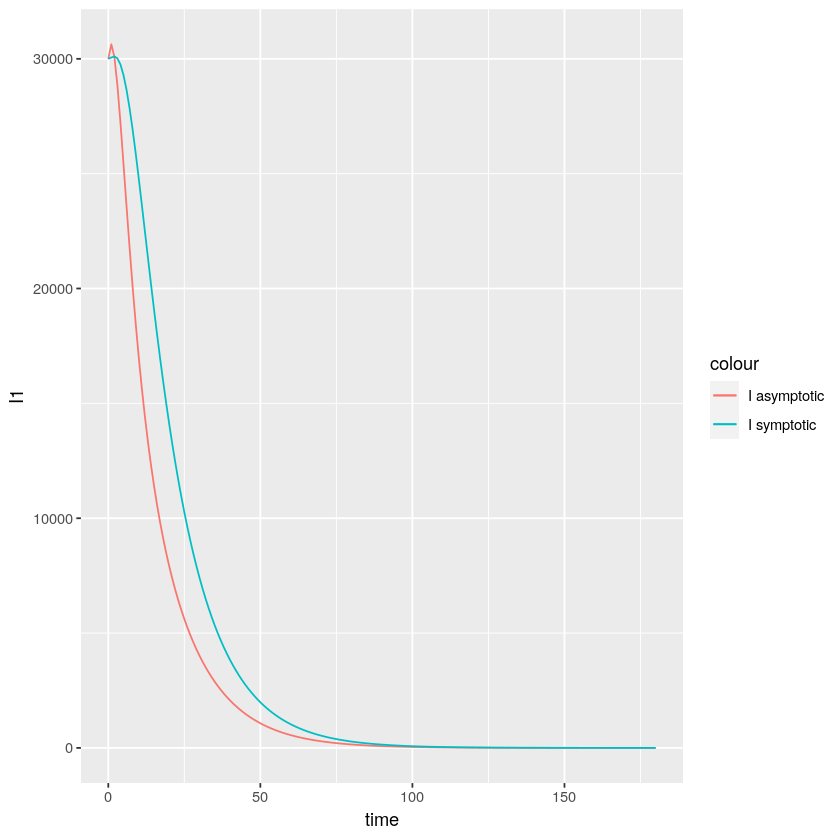

In [113]:
ggplot(NULL) + 
    geom_line(data = out4, aes(time, I1,colour="I asymptotic")) +
    geom_line(data = out4, aes(time, I2,colour="I symptotic"))

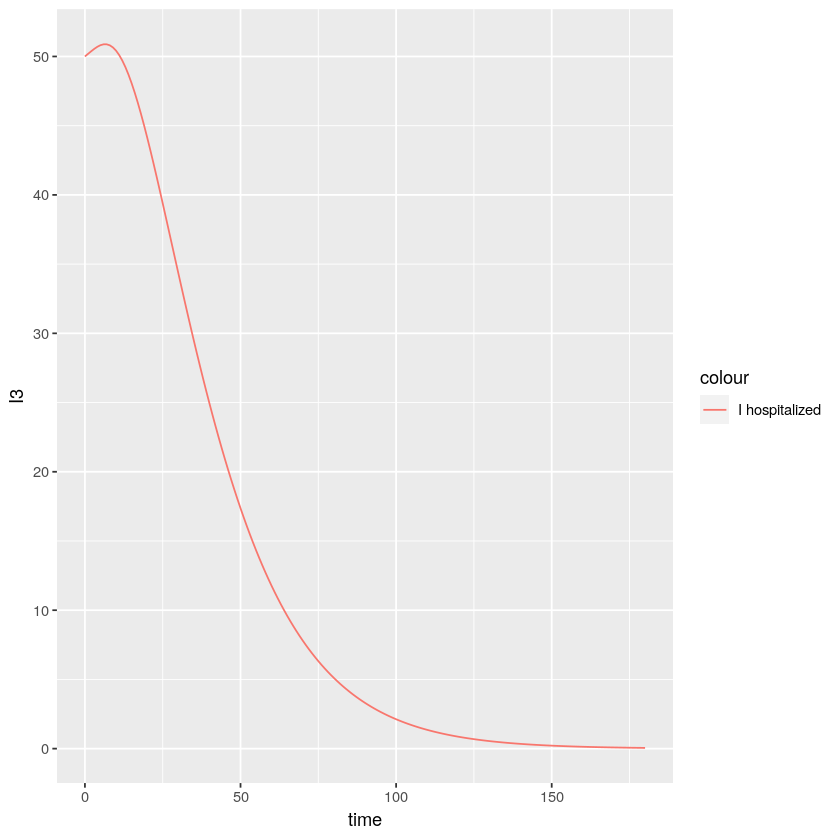

In [114]:
ggplot(NULL) + 
    geom_line(data = out4, aes(time, I3,colour="I hospitalized"))

Here it is predicted that the number of hospitalized persons decrease within 100 days.

Further notes based on the model assumptions,
- A high probability of infection between distant contacts i.e. in an afterski bar would lead to a very high transmission rate.
- Contact tracing and insulation from symptomatic cases would be relatively ineffective if symtomatic persons keep the number of contacts low. 
- Contact tracing using apps would potentially be useful for tracing of distant contacts. However, the number of contacts would be high, and the probability of these contacts having contracted COVID is low. Random testing in the population could be equally effective (or ineffective).
- Asymptomatic (i.e. everybody) should keep the probability of infection low, and the number of contacts low. then transmission will decrease rapidly.